In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sn
import urllib
from bs4 import BeautifulSoup
from re import T
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
# pip install pmdarimaimport warnings
warnings.filterwarnings("ignore")

### **Data Collection**

* **Data ccraping for Fed meeting related data**
* **Combine different datasets with inconsistent datetime**

In [81]:
#Scrape Fed meeting related data from https://www.investing.com

In [82]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0"
}
url = "https://www.investing.com/economic-calendar/interest-rate-decision-168"

request = urllib.request.Request(url,None,HEADERS)
file_req = urllib.request.urlopen(request)
file_data = file_req.read()

soup = BeautifulSoup(file_data)

In [84]:
soup = BeautifulSoup(soup)

In [85]:
Fed_list = []

for fed in soup.find_all("tr",{"event_attr_id":"168"}):
  date = fed.find("td",{"class":"left"}).text
  actual = fed.find("td",{"class":"noWrap"}).text
  previous = fed.find("td",{"class":"blackFont noWrap"}).text

  payload = [date, actual, previous]
  Fed_list.append(payload)

Fed_df = pd.DataFrame(Fed_list, columns=["date","Fed_rate","Fed_previous"])
Fed_df

#scrapd "Fed_rate"(Fed policy interest rate) & "Fed_previous"(interest rate of the previous meeting)

,date,Fed_rate,Fed_previous
0,"Dec 13, 2023",,
1,"Nov 01, 2023",,
2,"Sep 20, 2023",,
3,"Jul 26, 2023",,
4,"Jun 14, 2023",,
...,...,...,...
163,"Jan 03, 2001",6.00%,6.50%
164,"May 16, 2000",6.50%,6.00%
165,"Mar 21, 2000",6.00%,5.75%
166,"Feb 02, 2000",5.75%,5.50%


In [86]:
#turn "date" into datetime format and sort chronologically 

Fed_df["date"] = pd.to_datetime(Fed_df["date"])
Fed_df.sort_values(by=['date'], ascending=True,inplace=True)
Fed_df

,date,Fed_rate,Fed_previous
167,1999-11-16,5.50%,5.25%
166,2000-02-02,5.75%,5.50%
165,2000-03-21,6.00%,5.75%
164,2000-05-16,6.50%,6.00%
163,2001-01-03,6.00%,6.50%
...,...,...,...
4,2023-06-14,,
3,2023-07-26,,
2,2023-09-20,,
1,2023-11-01,,


In [87]:
#import another dataset "spx_df"

spx1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Bootcamp/Project/Final project/S&P 500 Historical Data_1.csv")
spx2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Bootcamp/Project/Final project/S&P 500 Historical Data_2.csv")
spx_df = pd.merge(spx1, spx2, how="outer")

spx_df["Date"] = pd.to_datetime(spx_df["Date"])
spx_df.rename(columns={"Date":"date", "Price":"SPX_price"},inplace=True)
spx_df

,date,SPX_price,Open,High,Low,Vol.,Change %
0,2000-01-03,"1,455.20","1,469.20","1,478.00","1,438.40",NaN,-0.95%
1,2000-01-04,"1,399.40","1,455.20","1,455.20","1,397.40",NaN,-3.83%
2,2000-01-05,"1,402.10","1,399.40","1,413.30","1,377.70",NaN,0.19%
3,2000-01-06,"1,403.50","1,402.10","1,411.90","1,392.00",NaN,0.10%
4,2000-01-07,"1,441.50","1,403.50","1,441.50","1,400.50",NaN,2.71%
...,...,...,...,...,...,...,...
5860,2023-04-19,"4,154.52","4,139.33","4,162.57","4,134.49",NaN,-0.01%
5861,2023-04-20,"4,129.79","4,130.48","4,148.57","4,114.57",NaN,-0.60%
5862,2023-04-21,"4,133.52","4,132.14","4,138.02","4,113.86",NaN,0.09%
5863,2023-04-24,"4,137.04","4,132.07","4,142.41","4,117.77",NaN,0.09%


In [88]:
#merge the "Fed_df" with "spx_df" to get "df"

df = pd.merge(spx_df,Fed_df,how="outer",on="date")
df.sort_values(by=['date'], ascending=True,inplace=True)
df #the orignial dataset: 9 columns and 5873 rows

,date,SPX_price,Open,High,Low,Vol.,Change %,Fed_rate,Fed_previous
5865,1999-11-16,NaN,NaN,NaN,NaN,NaN,NaN,5.50%,5.25%
0,2000-01-03,"1,455.20","1,469.20","1,478.00","1,438.40",NaN,-0.95%,NaN,NaN
1,2000-01-04,"1,399.40","1,455.20","1,455.20","1,397.40",NaN,-3.83%,NaN,NaN
2,2000-01-05,"1,402.10","1,399.40","1,413.30","1,377.70",NaN,0.19%,NaN,NaN
3,2000-01-06,"1,403.50","1,402.10","1,411.90","1,392.00",NaN,0.10%,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5868,2023-06-14,NaN,NaN,NaN,NaN,NaN,NaN,,
5869,2023-07-26,NaN,NaN,NaN,NaN,NaN,NaN,,
5870,2023-09-20,NaN,NaN,NaN,NaN,NaN,NaN,,
5871,2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,,


### **Data Cleaning & Feature Engineering**

**Data Cleaning**
*  Inconsistently-formatted strings
*  Inconsistent datetime from different datasets
*  Drop/Fill missing values
*  Drop irrelevant columns and numerize the variables for modeling
*  Inverse transformation of variables in percentage to level

**Feature Engineering**
* Create dummy variables
* Create categorical variables
* Create derived variables from other columns

In [89]:
#drop irrelevant columns

df.drop(["Open","High","Low","Vol.","Change %"],axis=1,inplace=True)

In [90]:
#manually create a dummy variable "Fed_meeting" for : whether there is a Fed meeting on that day

df["Fed_meeting"] = df["Fed_rate"].apply(lambda x: 1 if isinstance(x, str) else 0)
df

,date,SPX_price,Fed_rate,Fed_previous,Fed_meeting
5865,1999-11-16,NaN,5.50%,5.25%,1
0,2000-01-03,"1,455.20",NaN,NaN,0
1,2000-01-04,"1,399.40",NaN,NaN,0
2,2000-01-05,"1,402.10",NaN,NaN,0
3,2000-01-06,"1,403.50",NaN,NaN,0
...,...,...,...,...,...
5868,2023-06-14,NaN,,,1
5869,2023-07-26,NaN,,,1
5870,2023-09-20,NaN,,,1
5871,2023-11-01,NaN,,,1


In [91]:
df.info() 

##Problems needed to deal with:
#(1)"Fed_rate" and "Fed_previous" columns have multiple NA
#(2)"Price" column has few NA 
#(3)All variables are in string form

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5873 entries, 5865 to 5872
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5873 non-null   datetime64[ns]
 1   SPX_price     5865 non-null   object        
 2   Fed_rate      168 non-null    object        
 3   Fed_previous  168 non-null    object        
 4   Fed_meeting   5873 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 275.3+ KB


In [92]:
#"ffill" the NA in "Fed_rate" and "Fed_previous", since no data means no meeting that data thus no change in interest rate

df["Fed_rate"].fillna(method="ffill",inplace=True)
df["Fed_previous"].fillna(method="ffill",inplace=True)
df

,date,SPX_price,Fed_rate,Fed_previous,Fed_meeting
5865,1999-11-16,NaN,5.50%,5.25%,1
0,2000-01-03,"1,455.20",5.50%,5.25%,0
1,2000-01-04,"1,399.40",5.50%,5.25%,0
2,2000-01-05,"1,402.10",5.50%,5.25%,0
3,2000-01-06,"1,403.50",5.50%,5.25%,0
...,...,...,...,...,...
5868,2023-06-14,NaN,,,1
5869,2023-07-26,NaN,,,1
5870,2023-09-20,NaN,,,1
5871,2023-11-01,NaN,,,1


In [93]:
#check for the NA rows in "Price"

df[df["SPX_price"].isnull()]

,date,SPX_price,Fed_rate,Fed_previous,Fed_meeting
5865,1999-11-16,NaN,5.50%,5.25%,1
5866,2020-03-15,NaN,0.25%,1.25%,1
5867,2023-05-03,NaN,,5.00%,1
5868,2023-06-14,NaN,,,1
5869,2023-07-26,NaN,,,1
5870,2023-09-20,NaN,,,1
5871,2023-11-01,NaN,,,1
5872,2023-12-13,NaN,,,1


In [94]:
#drop the tail NAs(not yet available dates)
df.drop(df.index[5867:5873], inplace=True)

#drop the head NA
df.drop(df.index[0:1], inplace=True)

#for the 2020-03-15 row, here use "ffill" in order to keep the Fed-related data
df["SPX_price"].fillna(method="ffill",inplace=True)

df.isnull().sum() #all NA cleaned

date            0
SPX_price       0
Fed_rate        0
Fed_previous    0
Fed_meeting     0
dtype: int64

In [95]:
df.set_index('date', inplace=True)
df

,SPX_price,Fed_rate,Fed_previous,Fed_meeting
date,,,,
2000-01-03,"1,455.20",5.50%,5.25%,0
2000-01-04,"1,399.40",5.50%,5.25%,0
2000-01-05,"1,402.10",5.50%,5.25%,0
2000-01-06,"1,403.50",5.50%,5.25%,0
2000-01-07,"1,441.50",5.50%,5.25%,0
...,...,...,...,...
2023-04-19,"4,154.52",5.00%,4.75%,0
2023-04-20,"4,129.79",5.00%,4.75%,0
2023-04-21,"4,133.52",5.00%,4.75%,0


In [96]:
#deal with inconsistently-formatted strings: "," and "%"

df["SPX_price"] = df["SPX_price"].str.replace(",","")
df["Fed_rate"] = df["Fed_rate"].str.replace("%","")
df["Fed_previous"] = df["Fed_previous"].str.replace("%","")
df

,SPX_price,Fed_rate,Fed_previous,Fed_meeting
date,,,,
2000-01-03,1455.20,5.50,5.25,0
2000-01-04,1399.40,5.50,5.25,0
2000-01-05,1402.10,5.50,5.25,0
2000-01-06,1403.50,5.50,5.25,0
2000-01-07,1441.50,5.50,5.25,0
...,...,...,...,...
2023-04-19,4154.52,5.00,4.75,0
2023-04-20,4129.79,5.00,4.75,0
2023-04-21,4133.52,5.00,4.75,0


In [97]:
#numerize the variables for modeling

df["SPX_price"] = df["SPX_price"].astype(float)
df["Fed_rate"] = df["Fed_rate"].astype(float)
df["Fed_previous"] = df["Fed_previous"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5866 entries, 2000-01-03 to 2023-04-25
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SPX_price     5866 non-null   float64
 1   Fed_rate      5866 non-null   float64
 2   Fed_previous  5866 non-null   float64
 3   Fed_meeting   5866 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 229.1 KB


In [98]:
#check for the number of Fed meetings 

df["Fed_meeting"][df["Fed_meeting"]==1].count()

161

In [99]:
#a 161 sample size of independent variables in a 5866 sample size dataset might be too small
#so resample the dataset into monthly frequency

df_monthly = df.resample("1M").mean()
df_monthly['Fed_meeting'] = df_monthly['Fed_meeting'].apply(lambda x: 1 if x > 0 else 0)
#here we have to regenerate the dummy variables "Fed_meeting", since "resample.mean()" turns the "1" into other numbers
df_monthly

,SPX_price,Fed_rate,Fed_previous,Fed_meeting
date,,,,
2000-01-31,1425.595000,5.500000,5.250000,0
2000-02-29,1388.870000,5.737500,5.487500,1
2000-03-31,1442.221739,5.847826,5.597826,1
2000-04-30,1461.352632,6.000000,5.750000,0
2000-05-31,1418.477273,6.250000,5.875000,1
...,...,...,...,...
2022-12-31,3912.380952,4.285714,3.678571,1
2023-01-31,3960.656500,4.500000,4.000000,0
2023-02-28,4079.684737,4.750000,4.500000,1


In [100]:
#here in the total 280 sample size dataset, the number of Fed-meeting/No-meeting is 157/123
#this is a more balanced number, might increase the predictive power of the independent variables

print(
    len(df_monthly[df_monthly["Fed_meeting"]==1]),
    len(df_monthly[df_monthly["Fed_meeting"]==0])
)

157 123


In [101]:
#create the "SPX_return" column derived from "SPX_price"

df_monthly["SPX_return"] = df_monthly["SPX_price"].pct_change()
df_monthly.dropna(inplace=True) 
df_monthly = df_monthly[['SPX_price', 'SPX_return','Fed_rate', 'Fed_previous','Fed_meeting']]
#reposition the order of the columns
df_monthly

,SPX_price,SPX_return,Fed_rate,Fed_previous,Fed_meeting
date,,,,,
2000-02-29,1388.870000,-0.025761,5.737500,5.487500,1
2000-03-31,1442.221739,0.038414,5.847826,5.597826,1
2000-04-30,1461.352632,0.013265,6.000000,5.750000,0
2000-05-31,1418.477273,-0.029340,6.250000,5.875000,1
2000-06-30,1461.959091,0.030654,6.500000,6.000000,0
...,...,...,...,...,...
2022-12-31,3912.380952,-0.001304,4.285714,3.678571,1
2023-01-31,3960.656500,0.012339,4.500000,4.000000,0
2023-02-28,4079.684737,0.030053,4.750000,4.500000,1


In [102]:
#create a categorical variable "Fed_change" where 1 = increase in interest rate, 0 = unchanged and -1 = decrease

df_monthly["Fed_change"] = df_monthly["Fed_rate"] - df_monthly["Fed_previous"]
df_monthly['Fed_change'] = df_monthly['Fed_change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df_monthly.drop("Fed_previous",axis=1,inplace=True)

df_monthly #final dataset: 5 columns and 279 rows

,SPX_price,SPX_return,Fed_rate,Fed_meeting,Fed_change
date,,,,,
2000-02-29,1388.870000,-0.025761,5.737500,1,1
2000-03-31,1442.221739,0.038414,5.847826,1,1
2000-04-30,1461.352632,0.013265,6.000000,0,1
2000-05-31,1418.477273,-0.029340,6.250000,1,1
2000-06-30,1461.959091,0.030654,6.500000,0,1
...,...,...,...,...,...
2022-12-31,3912.380952,-0.001304,4.285714,1,1
2023-01-31,3960.656500,0.012339,4.500000,0,1
2023-02-28,4079.684737,0.030053,4.750000,1,1


### Dependent Variables
* ***(1) SPX_price*** : S&P 500 close price
* ***(2) SPX_return*** : S&P 500 return(%)

### Independent Variables
* ***(3) Fed_rate*** : Fed interest rate decision from the meeting
* ***(4) Fed_meeting*** : dummy variable for whether there is a Fed meeting on that month
* ***(5) Fed_change*** : categorical variable for the change of interest rate, where 1 = increase, 0 = unchagned, -1 = decrease

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>]], dtype=object)

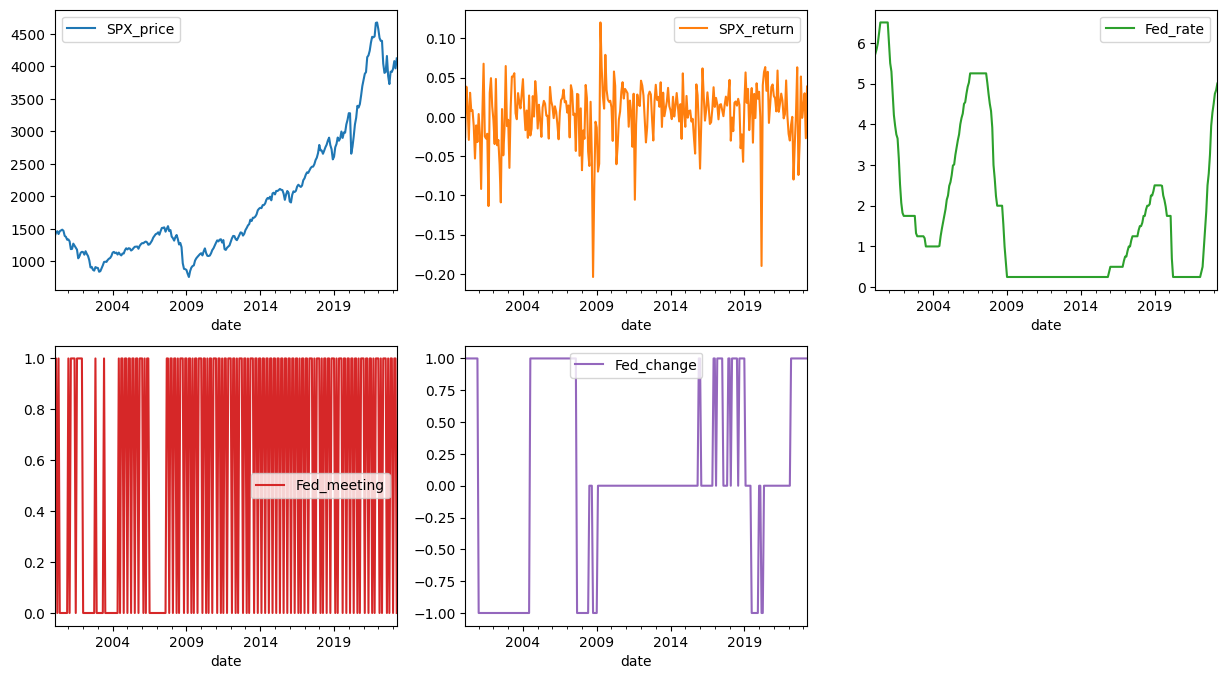

In [103]:
df_monthly.plot(
    subplots=True,
    layout=(2, 3),
    figsize=(15, 8),
    sharex=False
)

### **4. Modeling & Forecasting**
* Pre-modeling: examination of the predictive power of the variables
* **ARIMA**(AutoRegressive Integrated Moving Average) forecasting
* **VAR**(Vector AutoRegression) forecasting

In [104]:
#examination of the predictive power of the variables

Fed_meeting
0    0.001594
1    0.006847
Name: SPX_return, dtype: float64 



<Axes: xlabel='Fed_meeting', ylabel='SPX_return'>

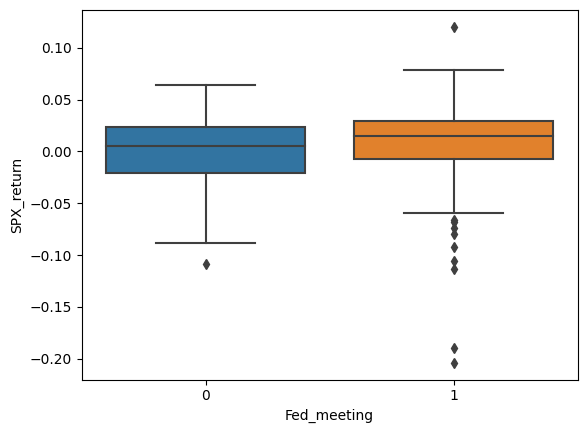

In [105]:
#examination(1): exploratory analysis

#Is there a difference in the average SPX returns when there is a Fed meeting on that month? 
print(df_monthly.groupby("Fed_meeting")["SPX_return"].mean(), "\n")
sn.boxplot(data=df_monthly,x="Fed_meeting",y="SPX_return")
#=> only a slight difference

Fed_change
-1   -0.008734
 0    0.012613
 1    0.002097
Name: SPX_return, dtype: float64 



<Axes: xlabel='Fed_change', ylabel='SPX_return'>

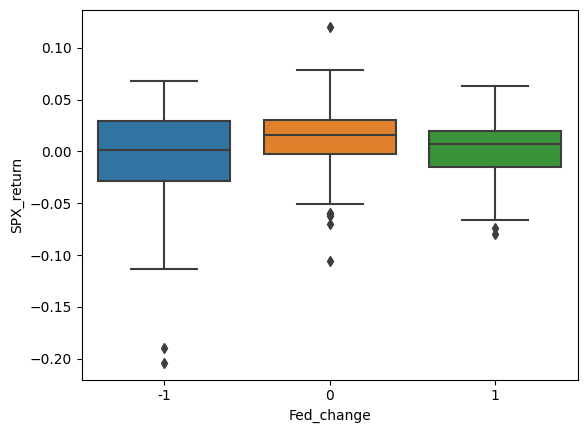

In [106]:
#Is there a difference in the average SPX returns when there the Fed increases/decreases/holds the interest rate ? 
print(df_monthly.groupby("Fed_change")["SPX_return"].mean(), "\n")
sn.boxplot(data=df_monthly,x="Fed_change",y="SPX_return")
#=> only a slight difference, but we can see that when the Fed leaves the interest rate unchanged, SPX returns tend to be a little higher

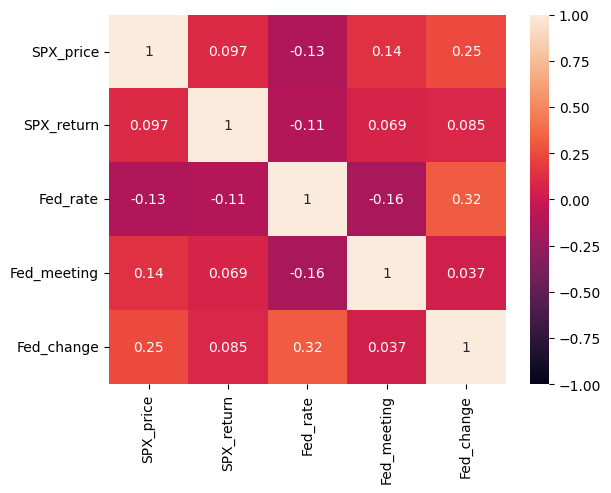

In [107]:
#examination(2): correlations between dependent variables(SPX_price/SPX_return) and independent variables(Fed_meeting/Fed_rate/Fed_change) are low

corr_matrix = df_monthly.corr()
sn.heatmap(corr_matrix, annot=True,vmax=1,vmin=-1)
plt.show()

In [108]:
#examination(3): R^2 from linear regression are also really low

x1 = df_monthly.loc[:,["Fed_rate"]]
x2 = df_monthly.loc[:,["Fed_meeting"]]
x3 = df_monthly.loc[:,["Fed_change"]]
y1 = df_monthly.loc[:,"SPX_price"]
y2 = df_monthly.loc[:,"SPX_return"]

linreg1 = LinearRegression()
linreg1.fit(x1,y1)

linreg2 = LinearRegression()
linreg2.fit(x2,y1)

linreg3 = LinearRegression()
linreg3.fit(x3,y1)

print(linreg1.score(x1,y1))
print(linreg2.score(x2,y1))
print(linreg3.score(x3,y1))

0.016290071213145296
0.018902787161360513
0.06196020512492706


In [109]:
#due to low correlations and low R^2 from linear regression, let's use time-series models that include Fed-data to forecast SPX
#here to better capture the potential effects of the Fed, I will treat x1/x2/x3 as both exogenous and endogenous variables

#(1)ARIMA model: include "Fed_meeting"(x2) and "Fed_change"(x3) as exogenous variables
#(2)VAR model: include "Fed_rate"(x1) as an endogeous variable

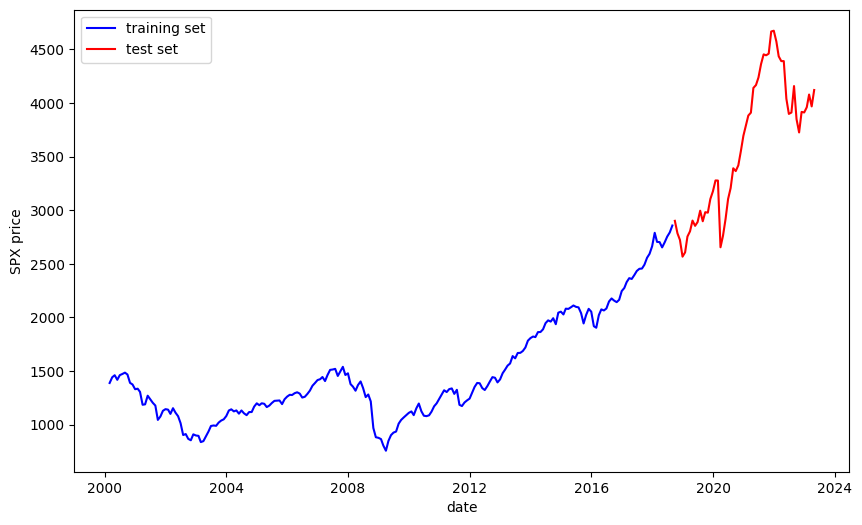

In [110]:
#split data into training set and test set
#note: for time-series data, "train_test_split" function reorders the datetime

train_portion = 0.8
train_rows = math.floor(len(df_monthly) * train_portion)
train = df_monthly[:train_rows]
test = df_monthly[train_rows:]

x1_train, x1_test = train["Fed_rate"], test["Fed_rate"]
x2_train, x2_test = train["Fed_meeting"], test["Fed_meeting"]
x3_train, x3_test = train["Fed_change"], test["Fed_change"]
y1_train, y1_test = train["SPX_price"], test["SPX_price"]
y2_train, y2_test = train["SPX_return"], test["SPX_return"]

plt.figure(figsize=(10,6))
plt.xlabel('date')
plt.ylabel('SPX price')
plt.plot(y1_train, 'blue', label='training set')
plt.plot(y1_test, 'red', label='test set')
plt.legend()

In [111]:
# build a model evaluator for the coming forecasting methods
## with inputs: (1)model type (2)variables (3)predicted value (4)actual value (5)exogenous variables
## and outputs: (1)forecast accuracy metrics~RMSE/MAPE/AIC (2)forecast plot

# note:
## MAPE (Mean Absolute Percentage Error) measures the average absolute percentage difference between the actual values and the predicted values.
## AIC (Akaike Information Criterion) measures the forecast quality of a time-series model, evaluating the relative goodness of fit of different models

model_tracker = pd.DataFrame({"Model":[],"Variables":[],"RMSE":[],"MAPE":[],"AIC":[]})

def evaluate_model(model,variables,y_test,y_pred,exog):

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  #for ARIMA models
  if "ARIMA" in model:
    mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
    aic = ar_model.aic  
    
    #to get the 95% confidence interval data
    forecast = ar_model.get_forecast(56,exog=exog)
    conf_int = forecast.conf_int(alpha=0.05)
    plt.fill_between(conf_int["lower SPX_price"].index, conf_int["lower SPX_price"], conf_int["upper SPX_price"], color='red', alpha=.1,label='95% C.I.')

  #for VAR models
  elif "VAR" in model:
    mape = np.mean(np.abs(pred_inverted["SPX_return_pred"] - test["SPX_price"])/np.abs(test["SPX_price"]))
    aic = var_model.aic

  payload = [model,variables,rmse,mape,aic]
  model_tracker.loc[len(model_tracker.index)] = payload
  
  plt.plot(y1_test, color="blue", label="actuals")
  plt.plot(y_pred,'m--', color="red", label="predicted")
  plt.title("SPX {} Prediction: {}".format(model,variables))
  plt.xlabel('Time')
  plt.ylabel('S&P 500 Price Level')
  plt.legend(loc='upper left')

  return model_tracker

In [112]:
#ARIMA modeling
#(1)original_model : the ARIMA model without including any Fed-related data as exogenous variables (only use the lags of prices itself)
#(2)test_model_x2: the ARIMA that includes "Fed_meeting"(x2) as exogenous variable
#(3)test_model_x3: the ARIMA that includes "Fed_change"(x3) as exogenous variable

#the purpose is to compare the "original model" with the "test models(x2/x3)", to see if Fed-related data improves the forecasting result

In [113]:
#use "auto_arima" function to determine the optimal parameters for ARIMA inputs

ar_model = auto_arima(y1_train, 
                      start_p=1, start_q=0, 
                      max_p=10, max_q=10,
                      seasonal=True, 
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=True)

print(ar_model.order, ar_model.seasonal_order)
# best (p,d,q) parameters = (1,2,2)
# no seasonal patttern => so no SARIMA, just ARIMA

(1, 2, 2) (0, 0, 0, 0)


,Model,Variables,RMSE,MAPE,AIC
0,ARIMA,Price(original_model),408.705005,0.080979,2335.403159


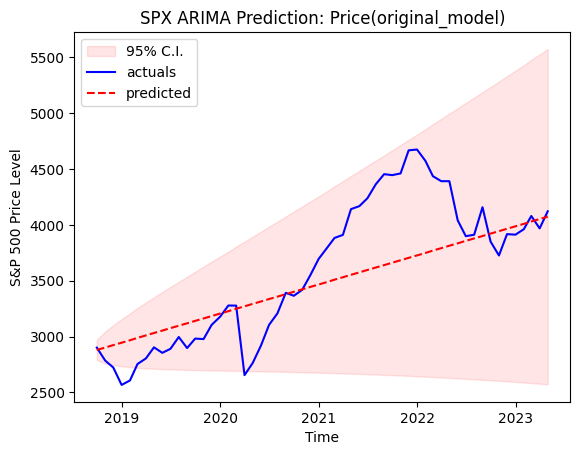

In [114]:
#ARIMA(1) original_model <- for comparing with other ARIMA models that include Fed-related data as exogenous variables

ar_model = ARIMA(y1_train,order=(1,2,2)) #without including any exogenous variable
ar_model = ar_model.fit()
ar_pred = ar_model.predict(start=y1_test.index[0],end=y1_test.index[-1])

evaluate_model("ARIMA","Price(original_model)",y1_test,ar_pred,None) #exog=None

,Model,Variables,RMSE,MAPE,AIC
0,ARIMA,Price(original_model),408.705005,0.080979,2335.403159
1,ARIMA,Price & Fed_meeting(x2),411.593266,0.081056,2334.599777


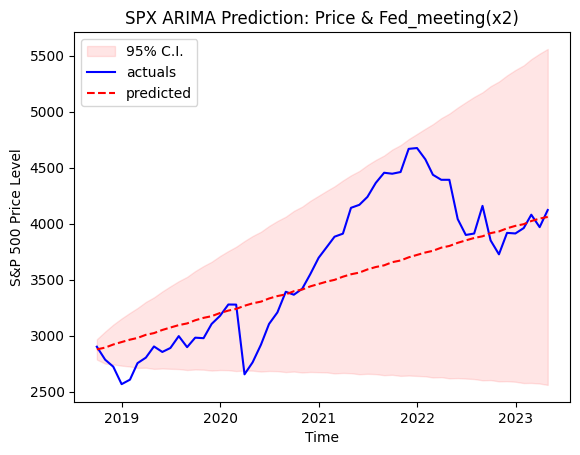

In [115]:
#ARIMA(2) test_model_x2 <- include "Fed_meeting"(x2) as exogenous variables

ar_model = ARIMA(y1_train,order=(1,2,2),exog=x2_train) #include x2 as exogenous variable
ar_model = ar_model.fit()
ar_x2_pred = ar_model.predict(start=y1_test.index[0],end=y1_test.index[-1],exog=x2_test)

evaluate_model("ARIMA","Price & Fed_meeting(x2)", y1_test, ar_x2_pred,x2_test) 
#result: compared to the original_model, test_model_x2 does not improve the predictive power from all three metrics

,Model,Variables,RMSE,MAPE,AIC
0,ARIMA,Price(original_model),408.705005,0.080979,2335.403159
1,ARIMA,Price & Fed_meeting(x2),411.593266,0.081056,2334.599777
2,ARIMA,Price & Fed_change(x3),408.852100,0.080859,2336.983447


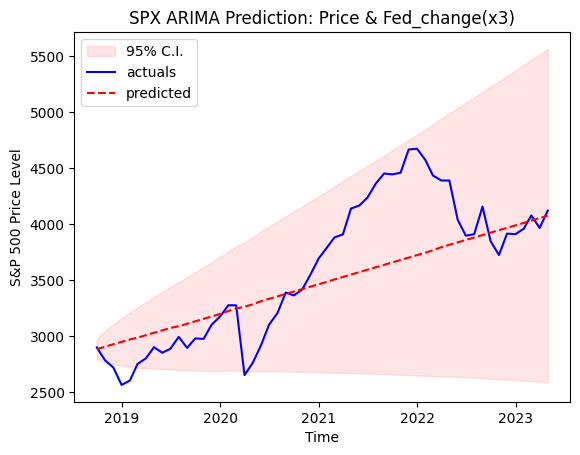

In [116]:
#ARIMA(3) test_model_x3 <- include "Fed_change"(x3) as exogenous variables

ar_model = ARIMA(y1_train,order=(1,2,2),exog=x3_train) #include x3 as exogenous variable
ar_model = ar_model.fit()
ar_x3_pred = ar_model.predict(start=y1_test.index[0],end=y1_test.index[-1],exog=x3_test)

evaluate_model("ARIMA","Price & Fed_change(x3)", y1_test, ar_x3_pred,x3_test) #exog=x3_test

#result: compared to the original_model, test_model_x3 does not improve the predictive power from all three metrics

In [117]:
#forecast SPX by including Fed-related data(x2:Fed_meeting, x3:Fed_change) as "exogenous" variables in "ARIMA model" does not work
#so let's try "VAR model" that includes Fed-related data(x1:Fed_rate) as "endogenous" variables

In [118]:
#before VAR modeling, we need to examine whether the time-series is stationarity, using ADF test

#ADF test for "SPX_price"(y1)
test_n = adfuller(y1_train,autolag='AIC', regression="c") 
print(f'ADF Statistic(y1:SPX_price): {test_n[0]}')
print(f'p-value: {test_n[1]}')
print('Critial Values:')
for key, value in test_n[4].items():
  print(f'   {key}, {value}')

print()

#ADF test for "SPX_return"(y2)
test_n = adfuller(y2_train,autolag='AIC', regression="c") 
print(f'ADF Statistic(y2:SPX_return): {test_n[0]}')
print(f'p-value: {test_n[1]}')
print('Critial Values:')
for key, value in test_n[4].items():
  print(f'   {key}, {value}')

#ADF test result(p-value) shows that SPX is not stationary at level(y1:SPX_price) but stationary after taking the difference(y2:SPX_return)
#so here, we choose "SPX_return"(y2) as our dependent variables for VAR modeling

ADF Statistic(y1:SPX_price): 1.4342828180537366
p-value: 0.9972644518403717
Critial Values:
   1%, -3.4602906385073884
   5%, -2.874708679520702
   10%, -2.573788599127782

ADF Statistic(y2:SPX_return): -5.607515940230804
p-value: 1.2246067513423545e-06
Critial Values:
   1%, -3.460849270544952
   5%, -2.87495318813585
   10%, -2.5739190539191745


In [119]:
#after checking for stationarity, we need to detemine the number of lags in the VAR model

df_var_x1 = df_monthly.drop(["SPX_price","Fed_meeting","Fed_change"],axis=1)
#creat a new dataset that only contains "SPX_return"(y2) and "Fed_rate"(x1)
var_model = VAR(df_var_x1)
lag_order = var_model.select_order(maxlags=5, trend='ct')
print(lag_order.summary())
print(lag_order.aic, lag_order.bic, lag_order.fpe)
#the results of the VAR order selection metrics(minimize the information criterion) suggest the optimal lags for this VAR model is 4

var_model = var_model.fit(4)
#so we use lag(4) to estimate the VAR model

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -5.592      -5.539    0.003728      -5.571
1      -10.05      -9.944   4.320e-05      -10.01
2      -10.67     -10.51*   2.325e-05     -10.61*
3      -10.66      -10.45   2.336e-05      -10.58
4     -10.70*      -10.44  2.256e-05*      -10.59
5      -10.69      -10.37   2.288e-05      -10.56
-------------------------------------------------
4 2 4


In [120]:
#split the data into training and test set
train_var_x1 = train.drop(["SPX_price","Fed_meeting","Fed_change"],axis=1)
test_var_x1 = test.drop(["SPX_price","Fed_meeting","Fed_change"],axis=1)

In [121]:
#generate the predicted series from the VAR model

pred = var_model.forecast(train_var_x1.values,steps=56)
pred = pd.DataFrame(pred, index=test_var_x1.index, columns=test_var_x1.columns+"_pred")
pred.drop("Fed_rate_pred",axis=1, inplace=True)
pred.head()

,SPX_return_pred
date,
2018-09-30,0.010482
2018-10-31,0.004104
2018-11-30,0.004768
2018-12-31,0.005391
2019-01-31,0.004429


In [122]:
#But here the predicted series is "return", so here we transform it back to "level"(SPX price)

pred_inverted = ((1 + pred).cumprod()) * test["SPX_price"].iloc[0]
pred_inverted.head()

,SPX_return_pred
date,
2018-09-30,2931.914434
2018-10-31,2943.947201
2018-11-30,2957.983569
2018-12-31,2973.930684
2019-01-31,2987.102305


,Model,Variables,RMSE,MAPE,AIC
0,ARIMA,Price(original_model),408.705005,0.080979,2335.403159
1,ARIMA,Price & Fed_meeting(x2),411.593266,0.081056,2334.599777
2,ARIMA,Price & Fed_change(x3),408.852100,0.080859,2336.983447
3,VAR,Price & Fed_rate(x1),537.842456,0.107125,-10.710791


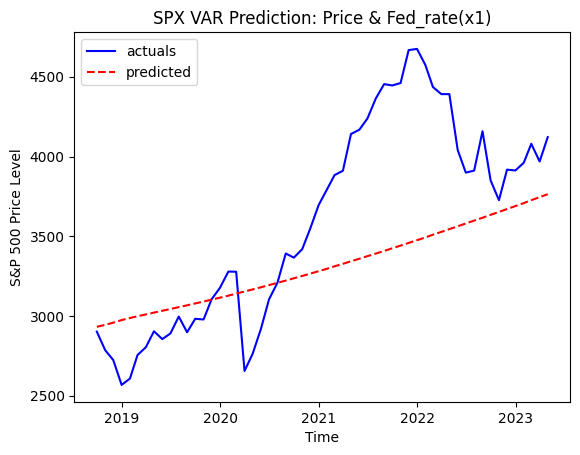

In [123]:
evaluate_model("VAR","Price & Fed_rate(x1)", y1_test, pred_inverted,None)

#result: compared to the ARIMA models, VAR model that includes "Fed_rate"(x1) as an endogenous variable does not improve the predictive power

In [124]:
#one useful feature of VAR model is Variance Decomposition, which decomposes the variance of a time series into the contributions of different factors
#so it basically tells us how important a shock from one variables(here:Fed_rate) is in explaining the variations of the target variable(here:SPX_price)

var_decomp = var_model.fevd(11)
var_decomp.summary()

#the result of variance decomposition shows that Fed_rate(x1) has almost no explanatory power (<1%) on SPX_price(y1), within 10 months periods

FEVD for SPX_return
      SPX_return  Fed_rate
0       1.000000  0.000000
1       0.996508  0.003492
2       0.996203  0.003797
3       0.995610  0.004390
4       0.995486  0.004514
5       0.995281  0.004719
6       0.995183  0.004817
7       0.994940  0.005060
8       0.994484  0.005516
9       0.993904  0.006096
10      0.993230  0.006770

FEVD for Fed_rate
      SPX_return  Fed_rate
0       0.043635  0.956365
1       0.064433  0.935567
2       0.068410  0.931590
3       0.074016  0.925984
4       0.069755  0.930245
5       0.063462  0.936538
6       0.058826  0.941174
7       0.054994  0.945006
8       0.051506  0.948494
9       0.048489  0.951511
10      0.045937  0.954063




In [125]:
#another handy feature of VAR model is Granger Causality, that examines whether one variable can help increase the accuracy for predicting a series
#so it basically tells us whether a variable is useful for forecasting, or whether we should include the variable in the model or not

granger = var_model.test_causality(caused="SPX_return", causing="Fed_rate", signif=0.05)
print(granger.summary())
#the result of Granger Causality test shows that "Fed_rate"(x1) does not granger-cause "SPX_return"(y2), meaning it does not improve predictive power

Granger causality F-test. H_0: Fed_rate does not Granger-cause SPX_return. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.238          2.389   0.294 (4, 532)
----------------------------------------------


### **Conclusions**
* The study tries to examine the relationship between Federal Reserve monetary policy meeting and S&P 500 index. This is a crucial quesiton since Fed policy rate directly affects the discount rate of equities and indirectly affects future cash flows by weighing on the economy, under a discounted cash flow valuation framework. **And most importantly, investors care!**
* But the empirical results of this study show that **Fed meeting-related data is not useful in forecasting equity prices, either included as** endogenous or exogenous variables in ARIMA and VAR model. Also, **correlation test, linear regression result, variance decomposition(from VAR) and granger causality test(from VAR) all support the forecasting result**.
* But no significant result is also an important result! The study implies that **asset managers should not use past Fed meeting related data to evalute the price of an equity asset, but focus on other factos instead.**